# Analytical Bayesian Model with Simulated Data

In this notebook we are using our Bayesian model to fit competitive binding experiment to fit simulated data.

In [1]:
#First we simulate some competitive binding data.
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
deltaG_L = -13.5 #kT
deltaG_B = -15.5 #kT

In [3]:
#This corresponds to Kd's of
Kd_L = np.exp(deltaG_L)
Kd_L

1.3709590863840845e-06

In [4]:
Kd_B = np.exp(deltaG_B)
Kd_B

1.8553913626159784e-07

In [5]:
#Competitive binding function
def three_component_competitive_binding_exact(Ptot, Ltot, K_L, Btot, K_B):
    """
    Parameters
    ----------
    Ptot : float
        Total protein concentration summed over bound and unbound species, molarity.
    Ltot : float
        Total fluorescent ligand concentration summed over bound and unbound speciesl, molarity.
    K_L : float
        Dissociation constant of fluoerscent L to P
    Btot : float
        Total competitive ligand concentration
    K_B : float
        Dissociation constant of B to B
        
    Returns
    -------
    P : float
        Free protein concentration
    L : float
        Free ligand concentration
    B : float
        Free ligand concentration
    PL : float
        Concentration of PA complex
    PB : float
        Concentration of PB complex
        
    Usage
    -----
    [P, L, B, PL, PB] = three_component_competitive_binding(Ptot, Ltot, K_L, Btot, K_B)
    """
    
    # P^3 + aP^2 + bP + c = 0
    a = K_L + K_B + Ltot + Btot - Ptot
    b = K_L*K_B + K_B*(Ltot-Ptot) + K_B*(Btot - Ptot)
    c = -K_L*K_B*Ptot
    
    # Subsitute P=u-a/3
    # u^3 - qu - r = 0 where 
    q = (a**2)/3.0 - b
    r = (-2.0/27.0)*a**3 +(1.0/3.0)*a*b - c
    
    # Discriminant
    delta = (r**2)/4.0 -(q**3)/27.0
    
    # 3 roots. Physically meaningful root is u.
    #theta = np.arccos((-2*(a**3)+9*a*b-27*c)/(2*np.sqrt((a**2-3*b)**3)))

    theta_intermediate = (-2*(a**3)+9*a*b-27*c)/(2*np.sqrt((a**2-3*b)**3))
        
    # this function prevents nans that occur when taking arccos directly
    def better_theta(theta_intermediate):
        global value
        if -1.0 <= theta_intermediate <= 1.0:
            value = np.arccos( theta_intermediate )
        elif theta_intermediate < -1.0:
            value = np.pi
        elif theta_intermediate > 1.0:
            value = 0.0
        return value
        
    theta = np.asarray(list(map(better_theta,theta_intermediate)))

    u = (2.0/3.0)*np.sqrt(a**2-3*b)*np.cos(theta/3.0)
    
    # Free protein concentration [P]
    P = u - a/3.0
    
    # [PA]
    PL = P*Ltot/(K_L + P)
    
    # [PB]
    PB = P*Btot/(K_B + P)
    
    # Free A concentration [A]
    L = Ltot - PL
    
    # Free B concentration [B]
    B = Btot - PB
    
    # Apparent Kd of L (shift caused by competitive ligand)
    # K_L_app = K_L*(1+B/K_B)
    
    return [P, L, B, PL, PB]

In [6]:
inputs = {
    'xml_file_path' :  "../../../assaytools/assaytools/examples/competition-fluorescence-assay/data/",
    'file_set'      :  {'Abl-IMA': glob("../../../assaytools/assaytools/examples/competition-fluorescence-assay/data/Abl*16-22-45_plate*.xml")},
    'ligand_order'  :  ['Gefitinib','Gefitinib','Gefitinib','Gefitinib'],
    'competitive_ligand'  :  'Imatinib',
    'section'       :  '280_BottomRead',
    'Lstated'       :  np.array([20.0e-6,9.15e-6,4.18e-6,1.91e-6,0.875e-6,0.4e-6,0.183e-6,0.0837e-6,0.0383e-6,0.0175e-6,0.008e-6,0.0], np.float64), # ligand concentration, M
    'Bstated'       :  10.0e-6 * np.ones([12],np.float64), # competitive ligand concentration, M
    'Pstated'       :  0.5e-6 * np.ones([12],np.float64), # protein concentration, M
    'assay_volume'  :  100e-6, # assay volume, L
    'well_area'     :  0.3969, # well area, cm^2 for 4ti-0203 [http://4ti.co.uk/files/3113/4217/2464/4ti-0201.pdf],
    'DG_L_mean'     :  -12.5, #DeltaG of Gefitinib mean estimate (kT)
    'DG_L_std'      :  1      #DeltaG of Gefitinib standard deviation estimate (kT)
    }

In [7]:
[P_bos_ima, L_bos_ima, B_bos_ima, PL_bos_ima, PB_bos_ima] = three_component_competitive_binding_exact(inputs['Pstated'][0], inputs['Lstated'], Kd_L, inputs['Bstated'][0], Kd_B)

In [10]:
sigma = 60.
F_background = 20000
F_PL = (40/1e-9)
F_L = (2/1e-8)

F_PL_i = F_background + F_PL * PL_bos_ima + F_L * L_bos_ima + sigma * np.random.randn()
F_L_i = F_background + F_L * L_bos_ima + sigma * np.random.randn()

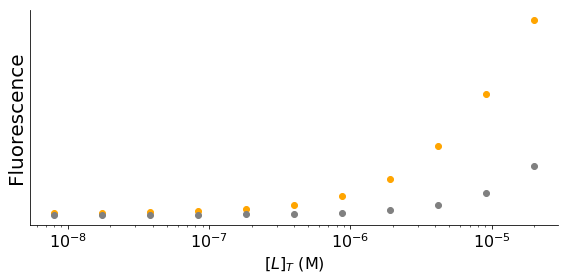

In [11]:
fig, ax = plt.subplots(figsize=(8,4))

plt.semilogx(inputs['Lstated'], F_PL_i,'o',color='orange',label='%s (M)'%inputs['Bstated'][0])

plt.semilogx(inputs['Lstated'],F_L_i,'o',color='gray',label='ligand')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('$[L]_T$ (M)',fontsize=16);
plt.yticks([])
plt.xticks(fontsize=16)
plt.ylabel('Fluorescence',fontsize=20);

plt.tight_layout()

## That's our simulated data, now let's try to fit it with our Bayesian model

In [12]:
# We know errors from our pipetting instruments.
P_error = 0.15
L_error = 0.08
B_error = 0.08

assay_volume = 100e-6 # assay volume, L

#Because we are interested in the orange value

dPstated = P_error * inputs['Pstated']
dLstated = L_error * inputs['Lstated']
dBstated = B_error * inputs['Bstated']

In [13]:
import pymc

In [14]:
DG_min = np.log(1e-15) # kT, most favorable (negative) binding free energy possible; 1 fM
DG_max = +0 # kT, least favorable binding free energy possible

In [15]:
#this is just for the lognormal wrapper and inner filter effect and run_mcmc
from assaytools import pymcmodels
from assaytools import bindingmodels

In [16]:
#This is our new competition assay model, which has competition as an option (note just for top fluroescence)
#if the values on the second line are included
def make_comp_model(Pstated, dPstated, Lstated, dLstated,
               Bstated = None, dBstated = None, DG_L_mean = None, DG_L_std = None, # specific for competition assay
               top_complex_fluorescence=None, top_ligand_fluorescence=None,
               DG_prior='uniform',
               concentration_priors='lognormal',
               quantum_yield_priors='lognormal',
               use_primary_inner_filter_correction=True,
               use_secondary_inner_filter_correction=True,
               assay_volume=100e-6, well_area=0.1586,
               epsilon_ex=None, depsilon_ex=None,
               epsilon_em=None, depsilon_em=None,
               ligand_ex_absorbance=None, ligand_em_absorbance=None,
               F_PL=None, dF_PL=None):

    # Compute path length.
    path_length = assay_volume * 1000 / well_area # cm, needed for inner filter effect corrections

    # Compute number of samples.
    N = len(Lstated)
    
    # Check input.
    # TODO: Check fluorescence and absorbance measurements for correct dimensions.
    if (len(Pstated) != N):
        raise Exception('len(Pstated) [%d] must equal len(Lstated) [%d].' % (len(Pstated), len(Lstated)))
    if (len(dPstated) != N):
        raise Exception('len(dPstated) [%d] must equal len(Lstated) [%d].' % (len(dPstated), len(Lstated)))
    if (len(dLstated) != N):
        raise Exception('len(dLstated) [%d] must equal len(Lstated) [%d].' % (len(dLstated), len(Lstated)))

    # Note whether we have top or bottom fluorescence measurements.
    top_fluorescence = (top_complex_fluorescence is not None) or (top_ligand_fluorescence is not None) # True if any top fluorescence measurements provided

    # Create an empty dict to hold the model.
    model = dict()
    
    # Prior on binding free energies.
    if DG_prior == 'uniform':
        DeltaG_B = pymc.Uniform('DeltaG_B', lower=DG_min, upper=DG_max) # binding free energy (kT), uniform over huge range
    elif DG_prior == 'chembl':
        DeltaG_B = pymc.Normal('DeltaG_B', mu=0, tau=1./(12.5**2)) # binding free energy (kT), using a Gaussian prior inspured by ChEMBL
    else:
        raise Exception("DG_prior = '%s' unknown. Must be one of 'uniform' or 'chembl'." % DG_prior)
    model['DeltaG_B'] = DeltaG_B
    
    # Prior on known binding free energy.
    if DG_L_mean == None:
        DeltaG_L = pymc.Uniform('DeltaG_L', lower=DG_min, upper=DG_max) # binding free energy (kT), uniform over huge range
    else:
        DeltaG_L = pymc.Normal('DeltaG_L', mu=DG_L_mean, tau=DG_L_std) 
    model['DeltaG_L'] = DeltaG_L
        
    if concentration_priors != 'lognormal':
        raise Exception("concentration_priors = '%s' unknown. Must be one of ['lognormal']." % concentration_priors)
    model['log_Ptrue'], model['Ptrue'] = pymcmodels.LogNormalWrapper('Ptrue', mean=Pstated, stddev=dPstated, size=Pstated.shape) # protein concentration (M)
    model['log_Ltrue'], model['Ltrue'] = pymcmodels.LogNormalWrapper('Ltrue', mean=Lstated, stddev=dLstated, size=Lstated.shape) # ligand concentration (M)
    model['log_Btrue'], model['Btrue'] = pymcmodels.LogNormalWrapper('Btrue', mean=Bstated, stddev=dBstated, size=Bstated.shape) # ligand concentration (M)
    model['log_Ltrue_control'], model['Ltrue_control'] = pymcmodels.LogNormalWrapper('Ltrue_control', mean=Lstated, stddev=dLstated, size=Lstated.shape) # ligand concentration in ligand-only wells (M)

    # extinction coefficient
    model['epsilon_ex'] = 0.0
    if use_primary_inner_filter_correction:
        if epsilon_ex:
            model['log_epsilon_ex'], model['epsilon_ex'] =  pymcmodels.LogNormalWrapper('epsilon_ex', mean=epsilon_ex, stddev=depsilon_ex) # prior is centered on measured extinction coefficient
        else:
            model['epsilon_ex'] = pymc.Uniform('epsilon_ex', lower=0.0, upper=1000e3, value=70000.0) # extinction coefficient or molar absorptivity for ligand, units of 1/M/cm

    model['epsilon_em'] = 0.0
    if use_secondary_inner_filter_correction:
        if epsilon_em:
            model['log_epsilon_em'], model['epsilon_em'] =  pymcmodels.LogNormalWrapper('epsilon_em', mean=epsilon_em, stddev=depsilon_em) # prior is centered on measured extinction coefficient
        else:
            model['epsilon_em'] = pymc.Uniform('epsilon_em', lower=0.0, upper=1000e3, value=0.0) # extinction coefficient or molar absorptivity for ligand, units of 1/M/cm

    # Min and max observed fluorescence.
    Fmax = 0.0; Fmin = 1e6;
    if top_complex_fluorescence is not None:
        Fmax = max(Fmax, top_complex_fluorescence.max()); Fmin = min(Fmin, top_complex_fluorescence.min())
    if top_ligand_fluorescence is not None:
        Fmax = max(Fmax, top_ligand_fluorescence.max()); Fmin = min(Fmin, top_ligand_fluorescence.min())

    # Compute initial guesses for fluorescence quantum yield quantities.
    F_plate_guess = Fmin
    F_buffer_guess = Fmin / path_length
    F_L_guess = (Fmax - Fmin) / Lstated.max()
    F_P_guess = Fmin
    F_P_guess = Fmin / Pstated.min()
    F_PL_guess = (Fmax - Fmin) / min(Pstated.max(), Lstated.max())

    # Priors on fluorescence intensities of complexes (later divided by a factor of Pstated for scale).

    if quantum_yield_priors == 'lognormal':
        stddev = 1.0 # relative factor for stddev guess
        model['log_F_plate'], model['F_plate'] =  pymcmodels.LogNormalWrapper('F_plate', mean=F_plate_guess, stddev=stddev*F_plate_guess) # plate fluorescence
        model['log_F_buffer'], model['F_buffer'] =  pymcmodels.LogNormalWrapper('F_buffer', mean=F_buffer_guess, stddev=stddev*F_buffer_guess) # buffer fluorescence
        model['log_F_buffer_control'], model['F_buffer_control'] =  pymcmodels.LogNormalWrapper('F_buffer_control', mean=F_buffer_guess, stddev=stddev*F_buffer_guess) # buffer fluorescence
        if (F_PL is not None) and (dF_PL is not None):
            model['log_F_PL'], model['F_PL'] =  pymcmodels.LogNormalWrapper('F_PL', mean=F_PL, stddev=dF_PL)
        else:
            model['log_F_PL'], model['F_PL'] =  pymcmodels.LogNormalWrapper('F_PL', mean=F_PL_guess, stddev=stddev*F_PL_guess) # complex fluorescence
        model['log_F_P'], model['F_P'] =  pymcmodels.LogNormalWrapper('F_P', mean=F_P_guess, stddev=stddev*F_P_guess) # protein fluorescence
        model['log_F_L'], model['F_L'] =  pymcmodels.LogNormalWrapper('F_L', mean=F_L_guess, stddev=stddev*F_L_guess) # ligand fluorescence
    else:
        raise Exception("quantum_yield_priors = '%s' unknown. Must be one of ['lognormal', 'uniform']." % quantum_yield_priors)

    # Unknown experimental measurement error.
    if top_fluorescence:
        model['log_sigma_top'] = pymc.Uniform('log_sigma_top', lower=-10, upper=np.log(Fmax), value=np.log(5))
        model['sigma_top'] = pymc.Lambda('sigma_top', lambda log_sigma=model['log_sigma_top'] : np.exp(log_sigma) )
        model['precision_top'] = pymc.Lambda('precision_top', lambda log_sigma=model['log_sigma_top'] : np.exp(-2*log_sigma) )

    if top_fluorescence:
        model['log_sigma_abs'] = pymc.Uniform('log_sigma_abs', lower=-10, upper=0, value=np.log(0.01))
        model['sigma_abs'] = pymc.Lambda('sigma_abs', lambda log_sigma=model['log_sigma_abs'] : np.exp(log_sigma) )
        model['precision_abs'] = pymc.Lambda('precision_abs', lambda log_sigma=model['log_sigma_abs'] : np.exp(-2*log_sigma) )

    if top_complex_fluorescence is not None:
        @pymc.deterministic
        def top_complex_fluorescence_model(F_plate=model['F_plate'], F_buffer=model['F_buffer'],
                                           F_PL=model['F_PL'], F_P=model['F_P'], F_L=model['F_L'],
                                           Ptrue=model['Ptrue'], Ltrue=model['Ltrue'], Btrue=model['Btrue'], DeltaG_L=model['DeltaG_L'], DeltaG_B=model['DeltaG_B'],
                                           epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            [P_i, L_i, PL_i, B_i, PB_i] = bindingmodels.CompetitionBindingModel.equilibrium_concentrations(Ptrue[:], Ltrue[:], DeltaG_L, Btrue[:], DeltaG_B)
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, L_i, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*L_i) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_PL*PL_i + F_L*L_i + F_P*P_i + F_buffer*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_complex_fluorescence_model'] = top_complex_fluorescence_model
        model['log_top_complex_fluorescence'], model['top_complex_fluorescence'] = pymcmodels.LogNormalWrapper('top_complex_fluorescence',
            mean=model['top_complex_fluorescence_model'], stddev=model['sigma_top'],
            size=[N], observed=True, value=top_complex_fluorescence) # observed data
        
    if top_ligand_fluorescence is not None:
        @pymc.deterministic
        def top_ligand_fluorescence_model(F_plate=model['F_plate'], F_buffer_control=model['F_buffer_control'],
                                          F_L=model['F_L'],
                                          Ltrue_control=model['Ltrue_control'],
                                          epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, Ltrue_control, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*Ltrue_control) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_L*Ltrue_control + F_buffer_control*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_ligand_fluorescence_model'] = top_ligand_fluorescence_model
        model['log_top_ligand_fluorescence'], model['top_ligand_fluorescence'] = pymcmodels.LogNormalWrapper('top_ligand_fluorescence',
                                                       mean=model['top_ligand_fluorescence_model'], stddev=model['sigma_top'],
                                                       size=[N], observed=True, value=top_ligand_fluorescence) # observed data
        
    #Below this is competition model stuff!    
    
    # Compute number of samples.
    if Bstated is not None:
        N_B = len(Bstated)

        # Check input.
        # TODO: Check fluorescence and absorbance measurements for correct dimensions.
        if (len(Lstated) != N_B):
            raise Exception('len(Lstated) [%d] must equal len(Bstated) [%d].' % (len(Lstated), len(Bstated)))
        if (len(Pstated) != N_B):
            raise Exception('len(Pstated) [%d] must equal len(Bstated) [%d].' % (len(Pstated), len(Bstated)))
        if (len(dPstated) != N_B):
            raise Exception('len(dPstated) [%d] must equal len(Bstated) [%d].' % (len(dPstated), len(Bstated)))
        if (len(dBstated) != N_B):
            raise Exception('len(dBstated) [%d] must equal len(Bstated) [%d].' % (len(dBstated), len(Bstated)))

            
    if Bstated is not None:
        @pymc.deterministic
        def top_complex_fluorescence_model(F_plate=model['F_plate'], F_buffer=model['F_buffer'],
                                           F_PL=model['F_PL'], F_P=model['F_P'], F_L=model['F_L'],
                                           Ptrue=model['Ptrue'], Ltrue=model['Ltrue'], Btrue=model['Btrue'],
                                           DeltaG_L=model['DeltaG_L'], DeltaG_B=model['DeltaG_B'],
                                           epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            [P_i, L_i, PL_i, B_i, PB_i] = bindingmodels.CompetitionBindingModel.equilibrium_concentrations(Ptrue[:], Ltrue[:], DeltaG_L, Btrue[:], DeltaG_B)
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, L_i, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*L_i) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_PL*PL_i + F_L*L_i + F_P*P_i + F_buffer*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_complex_fluorescence_model'] = top_complex_fluorescence_model
        model['log_top_complex_fluorescence'], model['top_complex_fluorescence'] = pymcmodels.LogNormalWrapper('top_complex_fluorescence',
            mean=model['top_complex_fluorescence_model'], stddev=model['sigma_top'],
            size=[N], observed=True, value=top_complex_fluorescence) # observed data

        @pymc.deterministic
        def top_ligand_fluorescence_model(F_plate=model['F_plate'], F_buffer_control=model['F_buffer_control'],
                                          F_L=model['F_L'],
                                          Ltrue_control=model['Ltrue_control'],
                                          epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, Ltrue_control, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*Ltrue_control) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_L*Ltrue_control + F_buffer_control*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_ligand_fluorescence_model'] = top_ligand_fluorescence_model
        model['log_top_ligand_fluorescence'], model['top_ligand_fluorescence'] = pymcmodels.LogNormalWrapper('top_ligand_fluorescence',
                                                       mean=model['top_ligand_fluorescence_model'], stddev=model['sigma_top'],
                                                       size=[N], observed=True, value=top_ligand_fluorescence) # observed data
    # Promote this to a full-fledged PyMC model.
    pymc_model = pymc.Model(model)

    # Return the pymc model
    return pymc_model

In [19]:
pymc_comp_model = make_comp_model(inputs['Pstated'], dPstated, inputs['Lstated'], dLstated,
    inputs['Bstated'], dBstated, inputs['DG_L_mean'], inputs['DG_L_std'],# specific for competition assay
    top_complex_fluorescence=F_PL_i,
    top_ligand_fluorescence=F_L_i,
    use_primary_inner_filter_correction=True,
    use_secondary_inner_filter_correction=True,
    assay_volume=assay_volume, DG_prior='uniform')

In [20]:
nburn = 500
niter = 50000
nthin = 20

In [21]:
comp_mcmc = pymc.MCMC(pymc_comp_model)
comp_mcmc.sample(iter=(nburn+niter), burn=nburn, thin=nthin, progress_bar=False, tune_throughout=True)

In [22]:
Abl_gefitinib = 2200e-9 # 2200 nM from DiscoverRx screen data 

AblGef_dG = np.log(Abl_gefitinib)

Abl_imatinib = 1.1e-9 # 1.1 nM from DiscoverRx screen data 

AblIma_dG = np.log(Abl_imatinib)

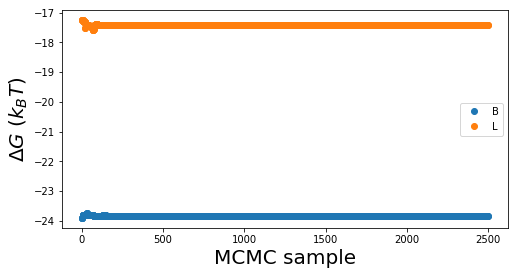

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(comp_mcmc.DeltaG_B.trace(),'o',label='B')
plt.plot(comp_mcmc.DeltaG_L.trace(),'o',label='L')
plt.ylabel('$\Delta G$ ($k_B T$)',fontsize=20);
plt.xlabel('MCMC sample',fontsize=20);
plt.legend()

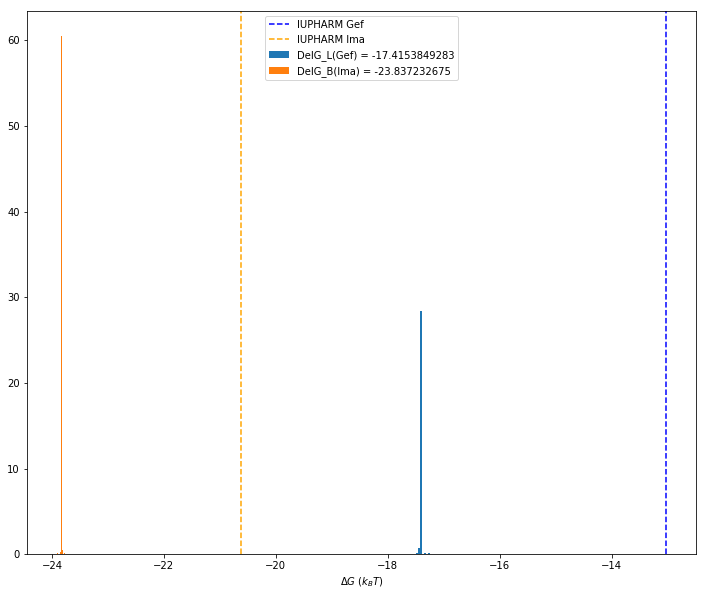

In [24]:
plt.figure(figsize=(12,10))
plt.hist(comp_mcmc.DeltaG_L.trace(),normed=True,label='DelG_L(Gef) = %s' %comp_mcmc.DeltaG_L.trace().mean());
plt.axvline(x=AblGef_dG,color='b',linestyle='--',label='IUPHARM Gef')
plt.hist(comp_mcmc.DeltaG_B.trace(),normed=True,label='DelG_B(Ima) = %s' %comp_mcmc.DeltaG_B.trace().mean());
plt.axvline(x=AblIma_dG,color='orange',linestyle='--',label='IUPHARM Ima')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.legend(loc=0);

/Users/hansons/anaconda2/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:3397: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


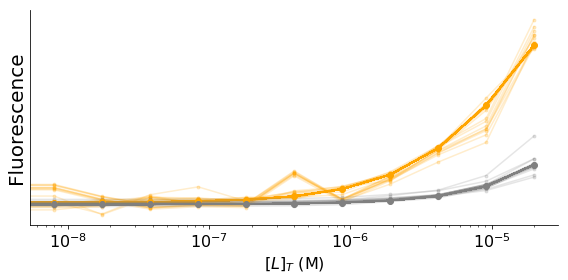

In [25]:
fig, ax = plt.subplots(figsize=(8,4))

for top_complex_fluorescence_model in comp_mcmc.top_complex_fluorescence_model.trace()[::10]:
    plt.semilogx(inputs['Lstated'], top_complex_fluorescence_model, color='orange',marker='.', alpha=0.2, hold=True)

for top_ligand_fluorescence_model in comp_mcmc.top_ligand_fluorescence_model.trace()[::10]:
    plt.semilogx(inputs['Lstated'], top_ligand_fluorescence_model, color='gray',marker='.', alpha=0.2, hold=True)
    
plt.semilogx(inputs['Lstated'], F_PL_i,'o',color='orange',label='%s (M)'%inputs['Bstated'][0])

plt.semilogx(inputs['Lstated'],F_L_i,'o',color='gray',label='ligand')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('$[L]_T$ (M)',fontsize=16);
plt.yticks([])
plt.xticks(fontsize=16)
plt.ylabel('Fluorescence',fontsize=20);

plt.tight_layout()